In [52]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import patsy
import statsmodels.api as sm

/Users/brandonkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
pd.options.mode.chained_assignment = None

# COGS108 Final Project
### Members:
- Brandon Kim A12850955
- Peter Tran A11305910
- Ren Salvania A12175053
- Victor Phung A10456527

## Introduction and Background

   Vehicles are a large part of the world we live in, and their importance in society explain the enormous number of vehicles on the road today. From trucks that carry cargo, to regular family cars and vans, cars are one of the most used forms of transportation in the United States. With such widespread use, it is inevitible that accidents happen, and quite frequently at that. There are many factors that play into what causes an accident, including but not limited to: driver error and the environment. We will be looking at data from the state of New York, as it is a good representation of a major city with prevalent vehiclular traffic in our society today. Specifically, we want to see if we can find any relationships between types of accidents and the contributing factors to them. <br> <br>
   We will be judging this based on three main criteria found within the dataset. Each row has a 'Prior Action' Column which denotes the type of accident/traffic violation as well as up to two contributing factors to each one along with descriptions. Each contributing factor falls under three categories: HUMAN, ENVMT, and VEHICLE and we will be using these categories to generally determine the most common cause of accident.

#### Research Question:
With so many car accidents that happen on the daily, safety is a major concern. To create a safer environment for drivers and pedestrians, what are the most common factors of accidents and what can be done to lower the chances of them happening?
#### Hypothesis:
Our hypothesis is that a combination of factors cause the most accidents with the environment being the most common. We feel that most singular incidents aren't enough to cause an accident whereas environmental issues are oftentimes unexpected and many drivers woln't be adequately prepared.

## Data and Description

Reads and stores the original dataframe from the dataset shown below.

Link: https://catalog.data.gov/dataset/motor-vehicle-crashes-vehicle-information-beginning-2009

In [9]:
df_orig = pd.read_csv('Motor_Vehicle_Crashes_-_Vehicle_Information__Three_Year_Window.csv')

The dataset from the link is a list of accidents that were reported to the NYS DMV over a three year period. For our use, we will be focusing on the 'Prior Actions', both the 'Contributing Factor' columns as well as their respective Description Columns

For reference, here are the original columns and their names:

In [10]:
list(df_orig)

['Year',
 'Case Vehicle ID',
 'Vehicle Body Type',
 'Registration Class',
 'Action Prior to Accident',
 'Type / Axles of Truck or Bus',
 'Direction of Travel',
 'Fuel Type',
 'Vehicle Year',
 'State of Registration',
 'Number of Occupants',
 'Engine Cylinders',
 'Vehicle Make',
 'Contributing Factor 1',
 'Contributing Factor 1 Description',
 'Contributing Factor 2',
 'Contributing Factor 2 Description',
 'Event Type',
 'Partial VIN']

## Data Cleaning/ Pre-processing

In [11]:
#This function converts these labels to NaNs if they are any of the four strings
#shown below. Returns orig label otherwise
def convert_nan(label):
    if (label == 'Not Applicable' or label == 'Not Entered'
       or label == 'Unknown' or label == 'Other'):
        return np.nan
    else:
        return label
    return label

The next cell drops columns within the original df that we deemed not necessary for the question that we are researching. Afterwords, we rename the columns so that it's easier to access. The first 5 rows will be shown as reference.

In [12]:
df = df_orig.drop(['Year', 'Case Vehicle ID', 'Direction of Travel', 
                   'Vehicle Body Type', 'Registration Class', 'Type / Axles of Truck or Bus',
                   'Direction of Travel', 'Fuel Type', 'Vehicle Year', 'Number of Occupants',
                   'Engine Cylinders', 'Vehicle Make','State of Registration', 
                   'Event Type', 'Partial VIN'], axis = 1)
df.columns = ['Prior Actions','Cont1', 
              'Cont1 Desc', 'Cont2', 'Cont2 Desc']
df.head()

,Prior Actions,Cont1,Cont1 Desc,Cont2,Cont2 Desc
0,Changing Lanes,HUMAN,Unsafe Lane Changing,HUMAN,Not Applicable
1,Going Straight Ahead,ENVMT,Pavement Slippery,HUMAN,Not Applicable
2,Going Straight Ahead,ENVMT,Pavement Slippery,HUMAN,Not Applicable
3,Going Straight Ahead,ENVMT,Pavement Slippery,ENVMT,Obstruction/ Debris
4,Going Straight Ahead,ENVMT,Pavement Slippery,HUMAN,Not Applicable


This cell first converts all values in each column to nans if any fall under the conditions shown in the convert_nan function (i.e. they are an element of the list {'Not Applicable', 'Not Entered', 'Unknown', 'Other'}). Afterwards, it'll remove any columns that have NaNs in all three of the set ['Prior Actions', 'Cond1 Desc', 'Cond2 Desc'] as they won't contribute anything to the data.

In [13]:
df = df.applymap(convert_nan)
df = df.dropna(subset = ['Prior Actions', 'Cont1 Desc', 'Cont2 Desc'], how = 'all')
df = df.dropna(subset = ['Cont1 Desc', 'Cont2 Desc'], how = 'all')
df = df.dropna(subset = ['Cont1', 'Cont2'], how = 'all')

After doing so, we will convert all nans in the 'Prior Actions' column back into 'Other' for ease of use:

In [14]:
df['Prior Actions'] = df['Prior Actions'].fillna('Other')

Additionally, we will be converting the Cont1 Desc and Cont2 Desc columns to 'N/A'

In [15]:
df['Cont1 Desc'] = df['Cont1 Desc'].fillna('N/A')
df['Cont2 Desc'] = df['Cont2 Desc'].fillna('N/A')

Finally, we will create multiple subsets of the data for each possible value in the 'Prior Actions' Column:

In [16]:
for i in df['Prior Actions'].unique():
    print (i)

Changing Lanes
Going Straight Ahead
Entering Parked Position
Slowing or Stopping
Backing
Making Right Turn
Making Left Turn
Making U Turn
Other
Starting from Parking
Starting in Traffic
Avoiding Object in Roadway
Overtaking/Passing
Merging
Stopped in Traffic
Parked
Making Right Turn on Red
Police Pursuit
Making Left Turn on Red


In [17]:
#Changing Lanes
df_changelanes = df.loc[df['Prior Actions'] == 'Changing Lanes']

#Going Straight Ahead
df_straight = df.loc[df['Prior Actions'] == 'Going Straight Ahead']

#Parked
df_parked = df.loc[df['Prior Actions'] == 'Parked']

#Entereing Parked Position
df_parking = df.loc[df['Prior Actions'] == 'Entering Parked Position']

#Slowing or Stopping
df_slowstop = df.loc[df['Prior Actions'] == 'Slowing or Stopping']

#Backing
df_backing = df.loc[df['Prior Actions'] == 'Backing']

#Stopped in Traffic
df_stoppedtraffic = df.loc[df['Prior Actions'] == 'Stopped in Traffic']

#Making Right Turn
df_rightturn = df.loc[df['Prior Actions'] == 'Making Right Turn']

#Making Left Turn
df_leftturn = df.loc[df['Prior Actions'] == 'Making Left Turn']

#Merging
df_merging = df.loc[df['Prior Actions'] == 'Merging']

#Making U Turn
df_uturn = df.loc[df['Prior Actions'] == 'Making U Turn']

#Other
df_other = df.loc[df['Prior Actions'] == 'Other']

#Starting in Traffic
df_trafficstart = df.loc[df['Prior Actions'] == 'Starting in Traffic']

#Starting from Parking
df_parkedstart = df.loc[df['Prior Actions'] == 'Starting from Parking']

#Avoiding Object in Roadwat
df_avoidobject = df.loc[df['Prior Actions'] == 'Avoiding Object in Roadway']

#Overtaking/Passing
df_passing = df.loc[df['Prior Actions'] == 'Overtaking/Passing']

#Making Right Turn on Red
df_redright = df.loc[df['Prior Actions'] == 'Making Right Turn on Red']

#Police Pursuit
df_police = df.loc[df['Prior Actions'] == 'Police Pursuit']

#Making Left Turn on Red
df_redleft = df.loc[df['Prior Actions'] == 'Making Left Turn on Red']

## Data Visualization

Here we will be presenting graphs on each dataset based on the contributing factors. There will be several main traits based off the values in the Cont1 and Cont2 columns which are:   <br> Human <br>Environment <br>Vehicle<br> Human + Environment<br> Enviroment + Vehicle <br> Vehicle + Human <br> Human + Human <br> Environment + Environment <br> Vehicle + Vehicle

The double values are there because there could be multiple factors of that type in an accident

Here is the function that we will be using to do that:

In [18]:
def Final_Conts(x, x_desc, y, y_desc):
    if(x_desc == 'N/A' and y_desc != 'N/A'):
        return y
    elif(x_desc != 'N/A' and y_desc == 'N/A'):
        return x
    else:
        if((x == 'HUMAN' and y == 'ENVMT') or (x == 'ENVMT' and y == 'HUMAN')):
            return 'HUMAN + ENVMT'
        elif((x == 'ENVMT' and y == 'VEHICLE') or (x == 'VEHICLE' and y == 'ENVMT')):
            return 'ENVMT + VEHICLE'
        elif((x == 'VEHICLE' and y == 'HUMAN') or (x == 'HUMAN' and y == 'VEHICLE')):
            return 'VEHICLE + HUMAN'
        else:
            return x + ' + ' + y

Text(0.5,0.98,'New York')

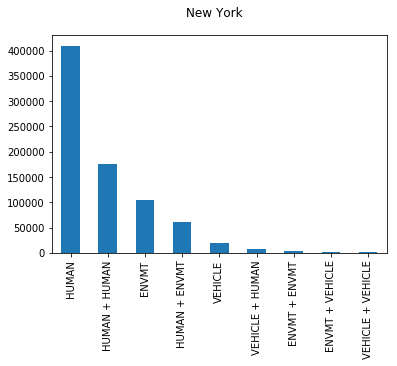

In [19]:
df['Final Cont'] = df.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("New York")

Text(0.5,0.98,'Changing Lanes')

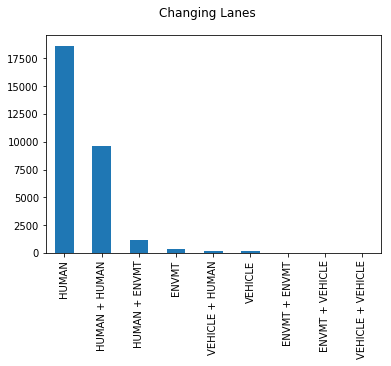

In [20]:
df_changelanes['Final Cont'] = df_changelanes.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_changelanes['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Changing Lanes")

Text(0.5,0.98,'Going Straight Ahead')

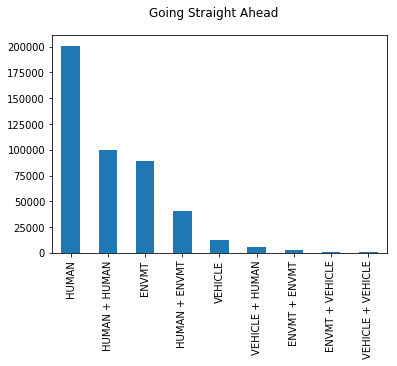

In [21]:
df_straight['Final Cont'] = df_straight.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_straight['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Going Straight Ahead")

Text(0.5,0.98,'Parked')

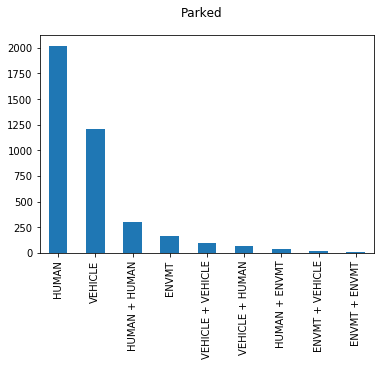

In [22]:
df_parked['Final Cont'] = df_parked.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_parked['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Parked")

Text(0.5,0.98,'Entering Parked Position')

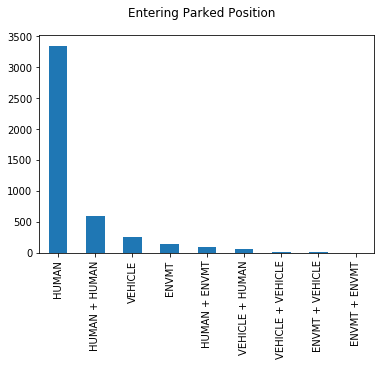

In [23]:
df_parking['Final Cont'] = df_parking.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_parking['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Entering Parked Position")

Text(0.5,0.98,'Slowing or Stopping')

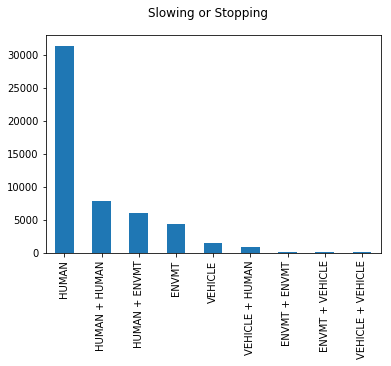

In [24]:
df_slowstop['Final Cont'] = df_slowstop.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_slowstop['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Slowing or Stopping")

Text(0.5,0.98,'Backing')

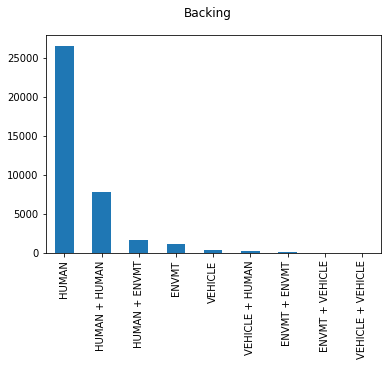

In [25]:
df_backing['Final Cont'] = df_backing.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_backing['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Backing")

Text(0.5,0.98,'Stopped in Traffic')

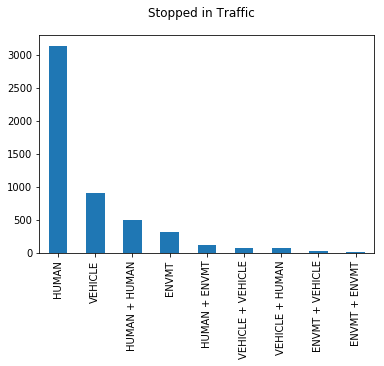

In [26]:
df_stoppedtraffic['Final Cont'] = df_stoppedtraffic.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_stoppedtraffic['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Stopped in Traffic")

Text(0.5,0.98,'Making Right Turn')

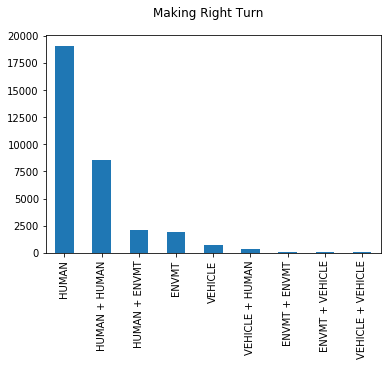

In [27]:
df_rightturn['Final Cont'] = df_rightturn.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_rightturn['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Making Right Turn")

Text(0.5,0.98,'Making Left Turn')

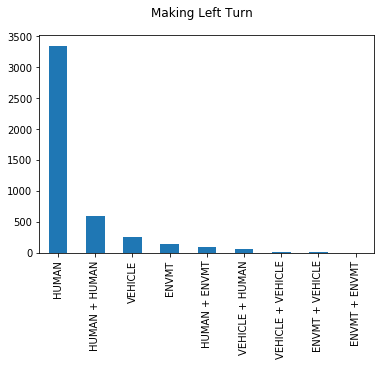

In [28]:
df_leftturn['Final Cont'] = df_leftturn.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_parking['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Making Left Turn")

Text(0.5,0.98,'Merging')

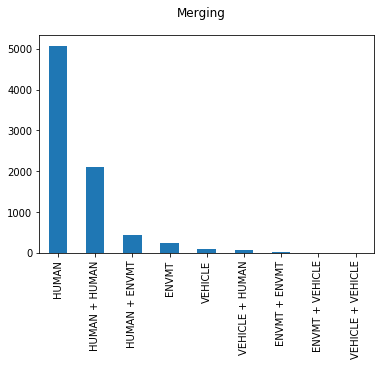

In [29]:
df_merging['Final Cont'] = df_merging.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_merging['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Merging")

Text(0.5,0.98,'Making U Turn')

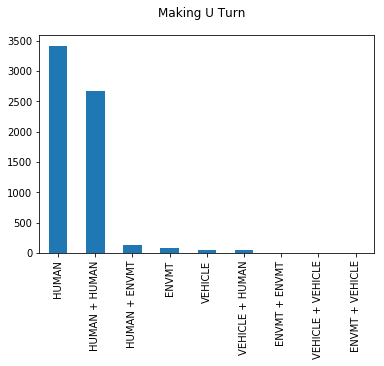

In [30]:
df_uturn['Final Cont'] = df_uturn.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_uturn['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Making U Turn")

Text(0.5,0.98,'Other')

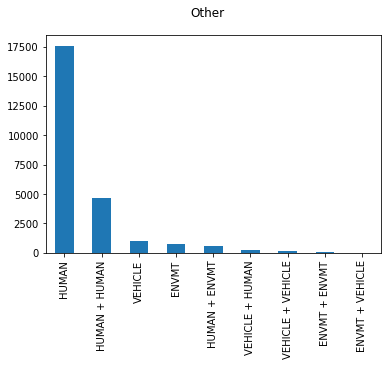

In [31]:
df_other['Final Cont'] = df_other.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_other['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Other")

Text(0.5,0.98,'Starting in Traffic')

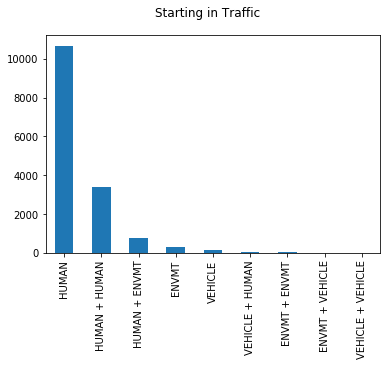

In [32]:
df_trafficstart['Final Cont'] = df_trafficstart.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_trafficstart['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Starting in Traffic")

Text(0.5,0.98,'Starting in Parking')

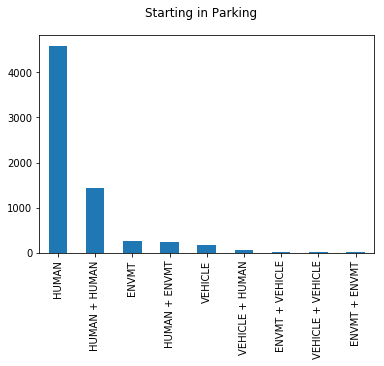

In [33]:
df_parkedstart['Final Cont'] = df_parkedstart.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_parkedstart['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Starting in Parking")

Text(0.5,0.98,'Avoiding Object in Roadway')

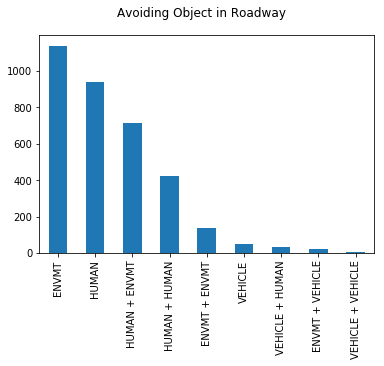

In [34]:
df_avoidobject['Final Cont'] = df_avoidobject.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_avoidobject['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Avoiding Object in Roadway")

Text(0.5,0.98,'Overtaking/Passing')

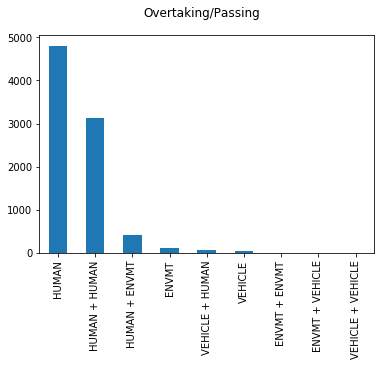

In [35]:
df_passing['Final Cont'] = df_passing.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_passing['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Overtaking/Passing")

Text(0.5,0.98,'Making Right Turn on Red')

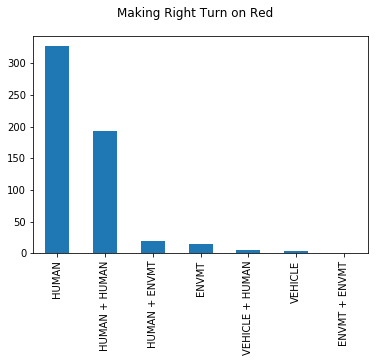

In [36]:
df_redright['Final Cont'] = df_redright.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_redright['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Making Right Turn on Red")

Text(0.5,0.98,'Police Pursuit')

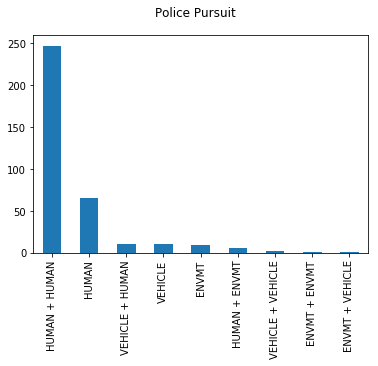

In [37]:
df_police['Final Cont'] = df_police.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_police['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Police Pursuit")

Text(0.5,0.98,'Making Left Turn on Red')

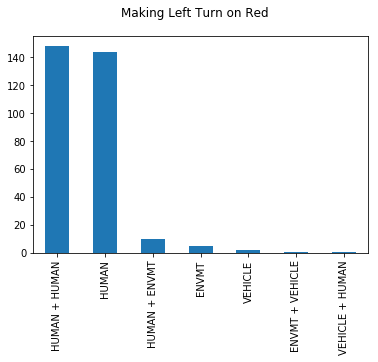

In [38]:
df_redleft['Final Cont'] = df_redleft.apply(lambda row: Final_Conts(row['Cont1'], row['Cont1 Desc'], row['Cont2'], row['Cont2 Desc']), axis = 1)
df_redleft['Final Cont'].value_counts().plot(kind='bar')
plt_ny = plt.gcf()
plt_ny.suptitle("Making Left Turn on Red")

## Data Analysis and Results

In [39]:
results = {'HUMAN':0, 'ENVMT':0, 'VEHICLE':0, 'HUMAN + HUMAN':0, 'ENVMT + ENVMT':0, 'VEHICLE + VEHICLE':0, 'HUMAN + ENVMT':0, 'VEHICLE + HUMAN':0, 'ENVMT + VEHICLE':0}
results

{'ENVMT': 0,
 'ENVMT + ENVMT': 0,
 'ENVMT + VEHICLE': 0,
 'HUMAN': 0,
 'HUMAN + ENVMT': 0,
 'HUMAN + HUMAN': 0,
 'VEHICLE': 0,
 'VEHICLE + HUMAN': 0,
 'VEHICLE + VEHICLE': 0}

The next few cells are used to show the most common Contributing Factors for each category. It will show the percentages of each one in the respective categories

In [40]:
def rank_top_3(res_series):
    assert isinstance(res_series, pd.Series)
    results[res_series.index[0]] += 3
    results[res_series.index[1]] += 2
    results[res_series.index[2]] += 1

In [41]:
rank_top_3(df['Final Cont'].value_counts())
rank_top_3(df_changelanes['Final Cont'].value_counts())
rank_top_3(df_straight['Final Cont'].value_counts())
rank_top_3(df_parked['Final Cont'].value_counts())
rank_top_3(df_parking['Final Cont'].value_counts())
rank_top_3(df_slowstop['Final Cont'].value_counts())
rank_top_3(df_backing['Final Cont'].value_counts())
rank_top_3(df_stoppedtraffic['Final Cont'].value_counts())
rank_top_3(df_rightturn['Final Cont'].value_counts())
rank_top_3(df_leftturn['Final Cont'].value_counts())
rank_top_3(df_merging['Final Cont'].value_counts())
rank_top_3(df_uturn['Final Cont'].value_counts())
rank_top_3(df_other['Final Cont'].value_counts())
rank_top_3(df_trafficstart['Final Cont'].value_counts())
rank_top_3(df_parkedstart['Final Cont'].value_counts())
rank_top_3(df_avoidobject['Final Cont'].value_counts())
rank_top_3(df_passing['Final Cont'].value_counts())
rank_top_3(df_redright['Final Cont'].value_counts())
rank_top_3(df_police['Final Cont'].value_counts())
rank_top_3(df_redleft['Final Cont'].value_counts())

for i in sorted(results.items(), key = operator.itemgetter(1), reverse = True):
    print (i[0] + ' : ' + str(i[1]))

HUMAN : 57
HUMAN + HUMAN : 38
HUMAN + ENVMT : 12
ENVMT : 6
VEHICLE : 6
VEHICLE + HUMAN : 1
ENVMT + ENVMT : 0
VEHICLE + VEHICLE : 0
ENVMT + VEHICLE : 0


In [42]:
def crash_percent(df_avg, df, col):
    crash_type = ['HUMAN','HUMAN + HUMAN','ENVMT','HUMAN + ENVMT','VEHICLE','VEHICLE + HUMAN','ENVMT + ENVMT','VEHICLE + VEHICLE','ENVMT + VEHICLE']
    for i in crash_type:
        if i in df['Final Cont'].value_counts():
            df_avg[i][col] = df['Final Cont'].value_counts()[i] / df['Final Cont'].value_counts().sum()
            df_avg[i][col] = str(round(df_avg[i][col],4)*100) + '%'
        else:
            df_avg[i][col] = '0.0%'
    return df_avg


In [94]:
arrays = [np.hstack([ ['HUMAN'], ['HUMAN + HUMAN'], ['ENVMT'], ['HUMAN + ENVMT'], ['VEHICLE'], ['VEHICLE + HUMAN'],['ENVMT + ENVMT'],['VEHICLE + VEHICLE'],['ENVMT + VEHICLE']])]
columns = pd.MultiIndex.from_arrays(arrays, names=['',''])
df_avg = pd.DataFrame(columns=columns,index=['Straight', 'Slow Stop','Change Lanes','Parked','Parking','Backing','Stopped Traffic','Right Turn','Left Turn','Merging','U-Turn','Traffic Start','Parked Start','Avoid Object','Passing','Red Right','Police','Red Left',' Other'])
crash_percent(df_avg, df_straight, 'Straight')
crash_percent(df_avg, df_slowstop, 'Slow Stop')
crash_percent(df_avg, df_changelanes, 'Change Lanes')
crash_percent(df_avg, df_parked, 'Parked')
crash_percent(df_avg, df_parking, 'Parking')
crash_percent(df_avg, df_backing, 'Backing')
crash_percent(df_avg, df_stoppedtraffic, 'Stopped Traffic')
crash_percent(df_avg, df_rightturn, 'Right Turn')
crash_percent(df_avg, df_leftturn, 'Left Turn')
crash_percent(df_avg, df_merging, 'Merging')
crash_percent(df_avg, df_uturn, 'U-Turn')
crash_percent(df_avg, df_trafficstart, 'Traffic Start')
crash_percent(df_avg, df_parkedstart, 'Parked Start')
crash_percent(df_avg, df_avoidobject, 'Avoid Object')
crash_percent(df_avg, df_passing, 'Passing')
crash_percent(df_avg, df_redright, 'Red Right')
crash_percent(df_avg, df_police, 'Police')
crash_percent(df_avg, df_redleft, 'Red Left')

df_avg

,HUMAN,HUMAN + HUMAN,ENVMT,HUMAN + ENVMT,VEHICLE,VEHICLE + HUMAN,ENVMT + ENVMT,VEHICLE + VEHICLE,ENVMT + VEHICLE
Straight,44.28%,22.06%,19.71%,9.06%,2.67%,1.17%,0.56%,0.22%,0.27%
Slow Stop,59.95%,14.97%,8.26%,11.41%,2.98%,1.58%,0.31%,0.21%,0.31%
Change Lanes,61.7%,31.94%,1.21%,3.93%,0.44%,0.58%,0.1%,0.05%,0.05%
Parked,51.47%,7.65%,4.18%,0.97%,30.68%,1.79%,0.31%,2.55%,0.41%
Parking,73.81%,13.07%,3.05%,1.99%,5.85%,1.55%,0.11%,0.38%,0.2%
Backing,69.85%,20.6%,3.09%,4.47%,0.92%,0.73%,0.16%,0.07%,0.11%
Stopped Traffic,60.75%,9.62%,6.22%,2.21%,17.54%,1.34%,0.37%,1.49%,0.46%
Right Turn,57.76%,25.89%,5.94%,6.33%,2.17%,1.16%,0.31%,0.2%,0.23%
Left Turn,63.37%,25.01%,3.51%,6.06%,1.02%,0.58%,0.27%,0.09%,0.09%
Merging,63.03%,26.21%,3.03%,5.37%,1.08%,0.81%,0.24%,0.11%,0.12%


In [136]:
#outcome, predictor = patsy.dmatrices("df_avg['ENVMT']['Straight'] ~ df_avg['HUMAN']['Straight']",df_avg)
#mod = sm.OLS(outcome, predictor)
#res = mod.fit()
#print(res.summary())
print(df_avg['HUMAN']['Straight'])
print(df_avg['ENVMT']['Straight'])

44.28%
19.71%


For the analysis, we will be using something akin to the Olympic Medal system. For each dataframe, we will rank the top three of each with first being worth 3 points, second being 2 points and third being 1 point. The rest get nothing. From the results, we see that the three categories: HUMAN, HUMAN + HUMAN, and HUMAN + ENVMT are the top three overall. <br> <br> Based on this, we can determine that the main cause of accidents are where the contributing factor is single HUMAN and that the next two are combinational factors with the addition that HUMAN is a component in each. This directly clashes with our hypothesis as we had beleived that 1: A combination of factors would be the most prevalent cause of accidents and 2: ENVMT would be the leading cause for accidents. <br> <br> As mentioned before, we found instead that HUMAN was the most common cause of accidents and when checking the percentages, we find that for each 'Prior Action', HUMAN tends to take up more than half of the reports in each of them. Furthermore, the combinational categories which involve HUMAN are all rated higher than other categories as well. In regards to this, we assume that these results attest to the notion that human error is the cause of the most accidents, intentional or not, and that other factors such as the environment or vehicle may influence the fact, but it is ultimately up to the person in question for accidents to occur.

## Privacy/ Ethics Considerations

The data we obtained already has been mostly anonymized according to the Safe Harbor method and there is no obviously personally identifiable information in the data anymore, except perhaps the partial VIN numbers of the vehicles and case vehicle ID. We have decided to drop those columns along with the others we deemed unnecessary as they are not needed for our analysis, as well as to make doubly certain that the final results of our findings will be completely anonymous. <br> <br>
As the number of drivers and vehicles present in New York State are quite high, the 'vehicle body type' field in the data is not specific enough to be considered a unique identifier. In other areas with smaller populations of drivers however, this field could turn out to help potentially identify someone, and with that in mind we dropped that column as well. <br> <br>
Another thing that we would like to avoid is creating biases that people may create upon looking at these results. For example, one can see that it's mostly human error that causes accidents and would focus solely on that while ignoring parts of the envrionment or their own vehicle's condition. The purpose of this is to bring to attention the most common reasons for accidents as well as show that many other factors can come into play as well.

## Conclusions and Discussion

In our analysis of the dataset, we compared each crash type and ranked them on which occurred the most. This led to an effective way to represent the combination of factors that contribute most to crashes in New York. Based on the analysis of our dataset, it appears that humans are the prime factor that cause most of the accidents that occur in New York. Our original hypothesis that environment is the leading cause of accidents in New York was proven to be false, and is only true in the case where an accident is caused by attempting to avoid an object on the road. In our hypothesis, we underestimated the role people play in avoiding accidents, and incorrectly believed that environmental factors like slippery roads and obstacles caused the most accidents. 

There exists many confounds in the data that may skew the results of the analysis, such as the ability/inability to drive of the people in a given population. Evidently, it is apparent that this is the case. For a region as populated as New York, there is a higher chance that there are more reckless or unskilled drivers. While our original hypothesis proved to be false, we could test another dataset from a different region that may potentially give us results that are different than what we have obtained here.

One way we have attempted to combat these confounds was by splitting each of the types of crashes into their own category. This contributes to a more in-depth analysis of each particular factor that causes each type of crash. By doing this, it was made evident to us that the environment plays a miniscule role in each crash.

What we can gather from this is that perhaps the most effective way to reduce accidents is to teach people to become better drivers, so that when the opportunity for an accident arises, the driver will be better prepared and have a higher chance to avoid it. In the future, we would like to analyze data from other states and regions as well and compare it to the results we obtained here to see if what we learned here agrees with that. It would be interesting to see if different environmental factors contribute to accidents more or if the percentage of human error based accidents compared to the total number of accidents are different in each area.

## Contributions

- Brandon Kim A12850955
> Data Analysis/ Results
> <br>Conclusions and Discussions

- Peter Tran A11305910
> Plotted the bar graph to Data Visualization using the method Final Cont
> <br> Created the dictionary to hold the ranking results from our data in Data Analysis
> <br> Added the method rank_top_3() to add the appropriate scores to the dictionary
> <br> Applied the method rank_top_3() to each of the keys in the dictionary in Data Analysis

- Ren Salvania A12175053
>Cleaning/Pre-Processing
> <br>Added subseting method (Final Cont)
> <br>Some text to the analysis and conclusion
- Victor Phung A10456527